# West vs. East resuspension rate difference classification

Based on tidal speeds from Jacqui-Lee

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import scipy.io

%matplotlib notebook

##### Parameters

In [6]:
xmin=1480; xmax=2180
ymin=160;  ymax=800

##### Load files:

In [7]:
mesh       = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

cond2      = (mesh_bathy > 0.1)
bathy_masked = np.ma.masked_where(cond2, mesh_bathy)

In [5]:
mat         = scipy.io.loadmat('/ocean/brogalla/GEOTRACES/data/mean_tide_speed.mat')
tidal_speed = mat['mean_speed']

ts_mesh     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/hsquare.nc')
ts_lons     = np.array(ts_mesh.variables['nav_lon'])
ts_lats     = np.array(ts_mesh.variables['nav_lat'])

##### Functions

In [7]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

##### Calculations

In [15]:
tidal_speed_ANHA12 = interp_np(ts_lons, ts_lats, tidal_speed, mesh_lon, mesh_lat)
tidal_speed_ANHA12[np.isnan(tidal_speed_ANHA12)] = 0

Based on my previous parameterization, I found that the erosion rate should be around a maximum of 8e-9 and a minimum of 0.25e-9 (or smaller) works. This means that tidal stress of 0.05 should be about 8e-9. So, I want the maximum of log10 of erosion rate to be about -8 and low areas to be around -10.

In [18]:
erosion_rate = 0.3e-6*tidal_speed_ANHA12**2
log_erosion_rate = np.log10(erosion_rate)

<IPython.core.display.Javascript object>


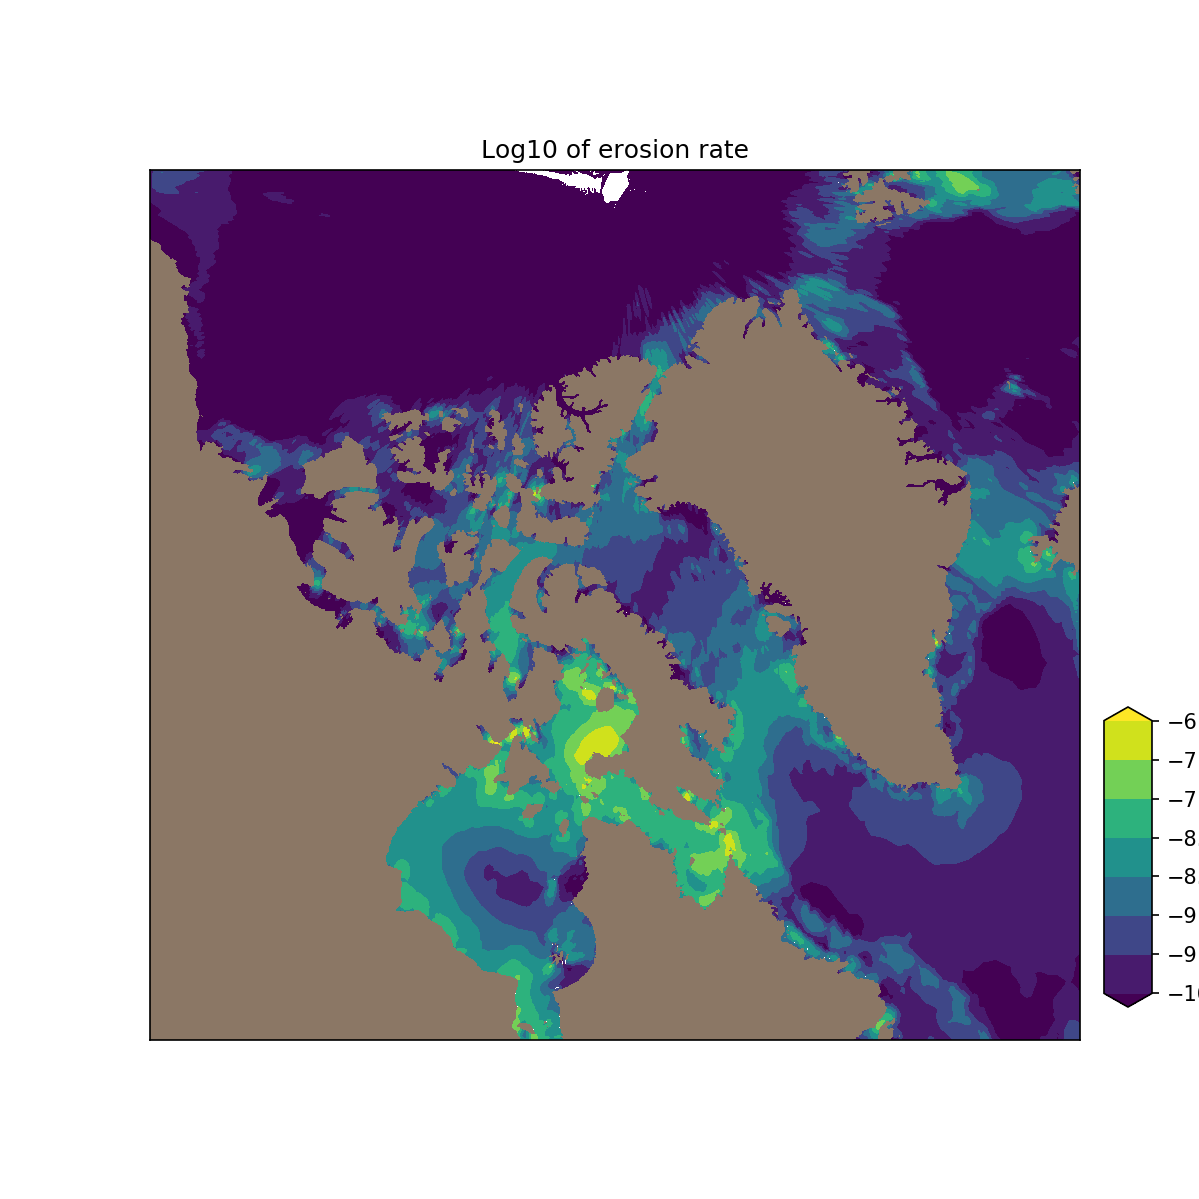

In [22]:
fig, ax1, proj1= pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/surface-Pb.pickle','rb'))

# Sub-domain map: ---------------------------------------------------------------------------
x_sub, y_sub  = proj1(mesh_lon, mesh_lat) 

# tidal stress:
plt_erosion_rate = np.ma.masked_where((mesh_bathy < 0.1), log_erosion_rate)
CB = proj1.contourf(x_sub, y_sub, plt_erosion_rate, vmin=-10, vmax=-6.5, \
                    levels=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5], extend='both')

ax1.set_title('Log10 of erosion rate')

cbaxes = fig.add_axes([0.92, 0.16, 0.04, 0.25])
CBar = plt.colorbar(CB, cax=cbaxes, ticks=[-10, -9.5, -9, -8.5, -8, -7.5, -7, -6.5])
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/Manuel---erosion-rate.png', bbox_inches='tight')

In [25]:
print('Units [g/m2/yr]')
print('Average erosion rate in domain: ', np.average(erosion_rate[xmin:xmax, ymin:ymax])*1000*365*24*3600)
print('Maximum erosion rate in domain: ', np.amax(erosion_rate[xmin:xmax, ymin:ymax])*1000*365*24*3600)
print('Minimum erosion rate in domain: ', np.amin(erosion_rate[xmin:xmax, ymin:ymax])*1000*365*24*3600)

Units [g/m2/yr]
Average erosion rate in domain:  38.28346936462349
Maximum erosion rate in domain:  7517.47397323373
Minimum erosion rate in domain:  0.0016871814765648647


In [24]:
merosion_rate = np.ma.masked_where((mesh_bathy < 0.1), erosion_rate)

print('Average erosion rate in domain: ', np.average(merosion_rate[xmin:xmax, ymin:ymax]))
print('Maximum erosion rate in domain: ', np.amax(merosion_rate[xmin:xmax, ymin:ymax]))
print('Minimum erosion rate in domain: ', np.amin(merosion_rate[xmin:xmax, ymin:ymax]))

Average erosion rate in domain:  8.139009939139963e-10
Maximum erosion rate in domain:  1.4302652156076348e-07
Minimum erosion rate in domain:  3.210010419643959e-14


##### Write to NetCDF file

In [26]:
c   = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_y2015m01d05_gridT.nc','r')
lon = np.array(c.variables['nav_lon'])
lat = np.array(c.variables['nav_lat'])

In [28]:
ncd = nc.Dataset('/ocean/brogalla/GEOTRACES/data/erosion_rate-20200221.nc', 'w', zlib=True)
ncd.createDimension('x',len(c.dimensions['x']))
ncd.createDimension('y',len(c.dimensions['y']))

# variables
nav_lat = ncd.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = lat

nav_lon = ncd.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = lon

mn_resus = ncd.createVariable('er_rate', 'float32', ('y','x'))
mn_resus.units = 'NA'
mn_resus.long_name = 'Erosion rate'  
mn_resus.coordinates = 'nav_lon nav_lat'
mn_resus[:] = erosion_rate

ncd.close()

In [14]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/erosion_rate-20200406.nc','r')
print(np.amax(c.variables['er_rate']))
print(np.amin(c.variables['er_rate']))
print(np.average(c.variables['er_rate']))

3.9184164e-07
0.0
8.4629737e-10
